In [1]:
import prefgen.external_modules.FECNet.models.FECNet
import prefgen.methods.similarity_optimization as similarity_optimization
import torch
import cv2
import numpy as np
from tqdm import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt

/storage/home/hcoda1/9/ahelbling6/.conda/envs/gan-search/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda"
stylegan_checkpoint = "pretrained/stylegan2-ffhq-config-f.pt"
stylegan_size = 1024
truncation = 0.7

similarity_mapper = similarity_optimization.load_similarity_mapper().to(device)
generator = similarity_optimization.load_stylegan2(stylegan_checkpoint, stylegan_size).to(device)

Loading state dict


In [3]:
# Generate a set of images
images = []
for i in range(100):
    mean_latent = generator.mean_latent(4096)
    latent_code_init_not_trunc = torch.randn(1, 512).cuda()
    with torch.no_grad():
        image, latent_code_init, _ = generator(
            [latent_code_init_not_trunc], 
            return_latents=True, 
            truncation=truncation, 
            truncation_latent=mean_latent
        )
    image = image.squeeze()
    images.append(image)

In [4]:
ims = images

In [53]:
import torchvision
batch_size = len(ims)
images = torch.stack(ims).squeeze()
# images = torchvision.utils.make_grid(images, nrow=batch_size, normalize=True, range=(-1, 1))

resized_images = []
for image in images:
    image += 1
    image /= 2
    image_out = torchvision.transforms.ToPILImage()(image)
    image_out = torchvision.transforms.Resize(224)(image_out)
    image_out = torchvision.transforms.ToTensor()(image_out)
    resized_images.append(image_out)

images = torch.stack(resized_images).squeeze()
# Rescale to proper range
images = images.mul(255).clamp_(0, 255).int()
# Change colors mode to BGR
permute = [2, 1, 0]
images = images[:, permute, :, :]
images = images.float()

In [54]:
# Embed the images into similarity space
similarity_vectors = []
for image in images:
    image = image.unsqueeze(0).cuda()
    sim_vec = similarity_mapper(image).squeeze().detach().cpu().numpy()
    similarity_vectors.append(sim_vec)

In [55]:
out_images = []
for image in images:
    image = image.squeeze().int().detach().cpu().numpy()
    out_images.append(image)
images = out_images

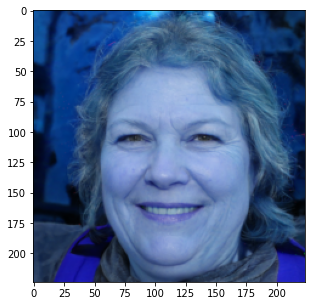

In [56]:
plt.figure(figsize=(5, 5))
out_image = images[1]
out_image = out_image.transpose((1, 2, 0))
plt.imshow(out_image)
plt.show()

In [81]:
# Compute the tsne coordinates of the images
from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2).fit_transform(similarity_vectors)
tsne = similarity_vectors[:][0:2]

In [82]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

TypeError: list indices must be integers or slices, not tuple

In [83]:
plot_size = 4000
# Compute the coordinates of the image on the plot
def compute_plot_coordinates(image, x, y, image_centers_area_size=plot_size-225, offset=100):
    # print(image.shape)
    # print(x, y)
    image_height, image_width, _ = image.shape

    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset

    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center,
    # compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)
    
    # print(tl_x, tl_y)

    br_x = tl_x + image_width
    br_y = tl_y + image_height
    
    # print(br_x - tl_x)
    return tl_x, tl_y, br_x, br_y

# we'll put the image centers in the central area of the plot
# and use offsets to make sure the images fit the plot

# init the plot as white canvas
tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)

# now we'll put a small copy of every image to its corresponding T-SNE coordinate
for image, x, y in tqdm(
        zip(images, tx, ty),
        desc='Building the T-SNE plot',
        total=len(images)
):
    # scale the image to put it to the plot
    # image = scale_image(image, max_image_size)
    image = torch.Tensor(image)
    image = image.permute((1, 2, 0))
    permute = [2, 1, 0]
    image = image[:, :, permute]
    try:
        # compute the coordinates of the image on the scaled plot visualization
        tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y)

        # put the image to its t-SNE coordinates using numpy sub-array indices
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image
    except:
        pass

cv2.imwrite('tsnefile.jpg', tsne_plot)


Building the T-SNE plot: 100%|██████████| 100/100 [00:00<00:00, 1007.54it/s]


True

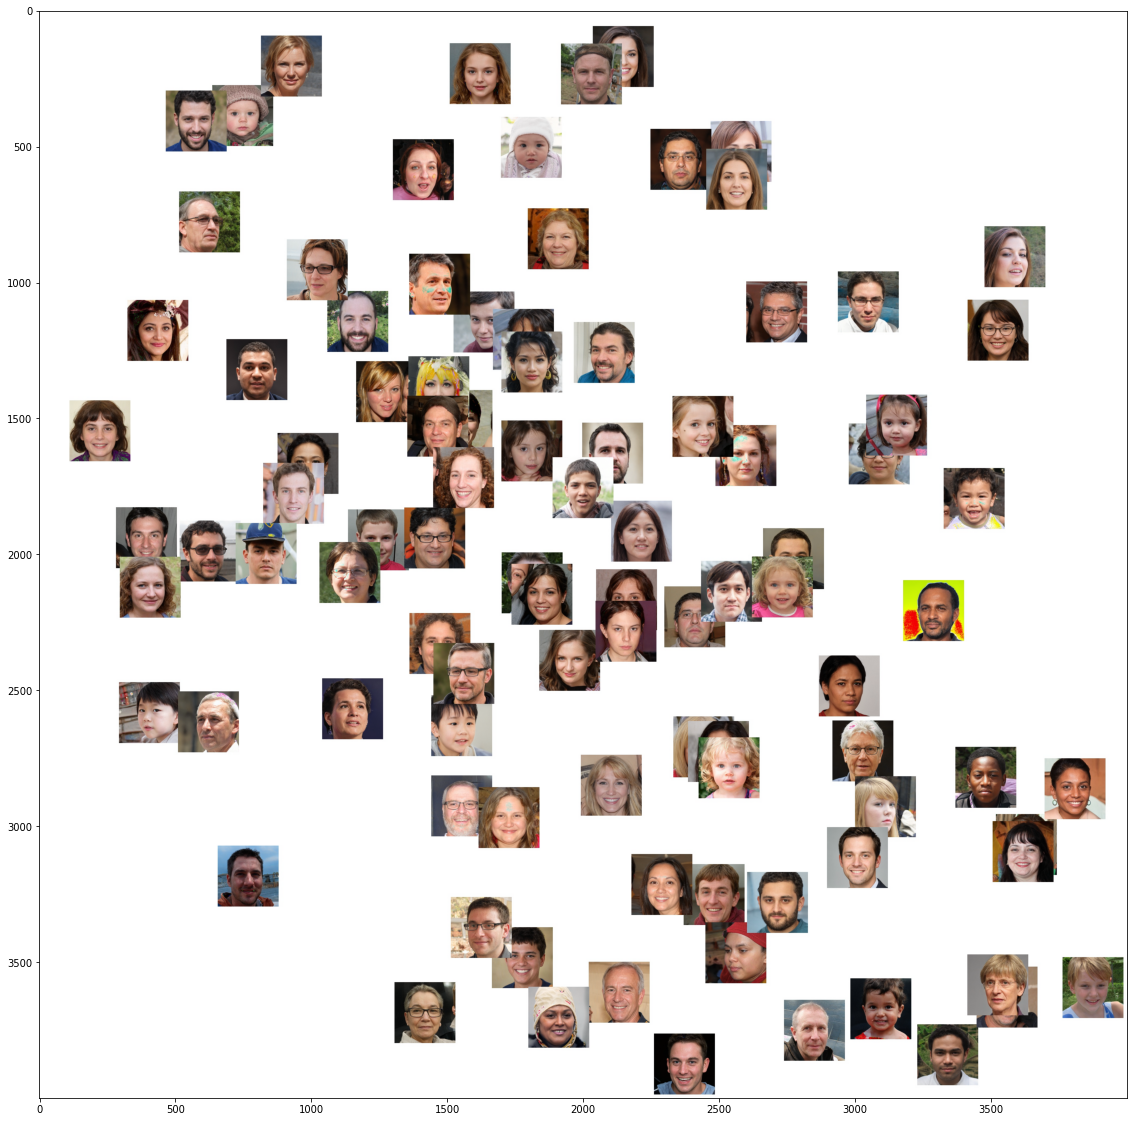

In [84]:
#Import image
image = cv2.imread("tsnefile.jpg")
#Show the image with matplotlib
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.show()